# Course Information
DDS8555 - Predictive Analysis<br>
Assignment 6<br>
Implement Tree Models and participate in [Multi-class Prediction of Obesity Risk from Kaggle.com](https://www.kaggle.com/competitions/playground-series-s4e2/overview).

By - Samuel Mbah Nde
Due Date and Time: Sunday March 3rd 2025 at 11:59PM PST.

# Conceptual Questions

This file contains solutions to the conceptual questions from ISLP python that are part of this week's assignments. There are 2 questions, Conceptual question 1 and question 13 from chapter 4.

## Import the packages needed analyze data.
I will load all the packages needed in one place to keep my code organized.

In [410]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import probplot
import re, os, json, requests, random
from datetime import datetime, timedelta, timezone
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score,
                            accuracy_score, f1_score, precision_score, recall_score)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report 
from sklearn import datasets
from ISLP import load_data, confusion_table
from ISLP.models import (summarize,
                         poly,
                         ModelSpec)
from functools import partial
from statsmodels.gam.api import BSplines
from statsmodels.stats.anova import anova_lm

## Set seed to ensure work is reproducible.

In [412]:
random.seed(6222)

## Conceptual Question 1

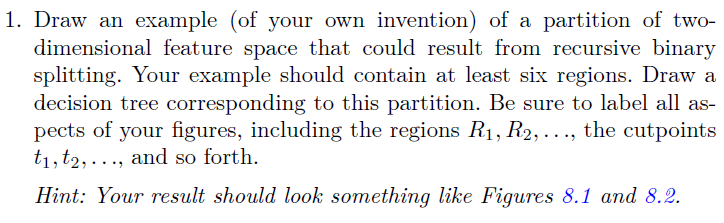

## Problem decided.
I decided to use a model for home prices that are based on Number of rooms in the home and the year the home was built. 

This decision tree represents a simplified model for predicting home prices based on the year built and number of rooms, with prices in thousands of dollars. Homes built before 2005 are split into two branches: those built before 1978 and those built in or after 2014. Homes built before 1978 are further divided by the number of rooms, with homes having fewer than 4 rooms priced at \$160,000 or \$200,000, and homes with 5 or more rooms priced at \$220,000. Homes built in or after 2014 are also divided by room count, with homes having fewer than 3 rooms priced at \$200,000 or \$250,000, and homes with 4 or more rooms priced at \$270,000 or $300,000.

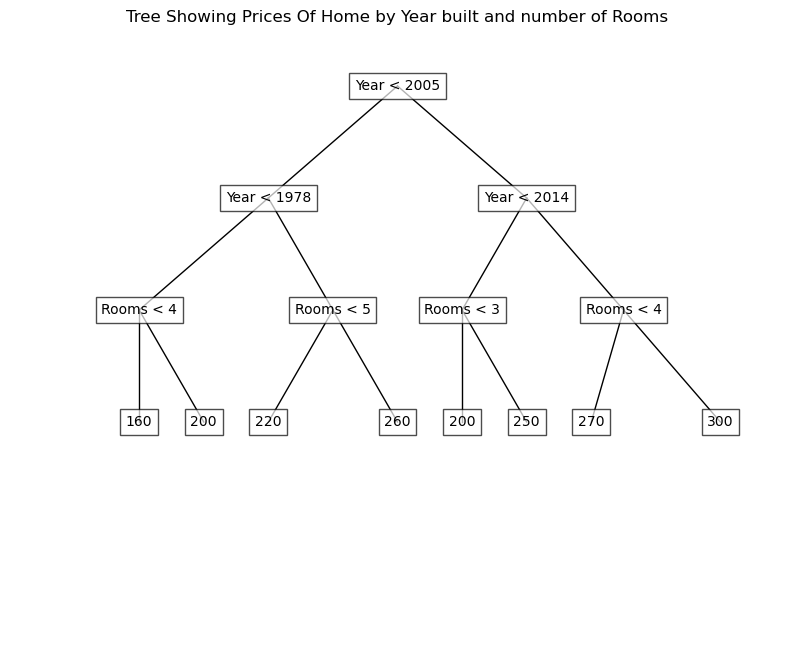

In [416]:
def draw_decision_tree():
    """Draws the decision tree diagram."""

    # Node positions (x, y)
    node_positions = {
        'year_2005': (0.5, 1),
        'year_2014': (0.7, 0.8),
        'year_1978': (0.3, 0.8),
        'rooms_3_5': (0.1, 0.6),
        'rooms_3_5_2': (0.3, 0.6),
        'rooms_5_5': (0.4, 0.6),
        'rooms_3_5_2': (0.6, 0.6),
        'rooms_4': (0.85, 0.6),
        'leaf_160': (0.1, 0.4),
        'leaf_200': (0.2, 0.4),
        'leaf_220': (0.3, 0.4),
        'leaf_260': (0.5, 0.4),
        'leaf_200_2': (0.6, 0.4),
        'leaf_270': (0.8, 0.4),
        'leaf_250_2': (0.7, 0.4),
        'leaf_300': (1, 0.4),
    }

    # Node labels
    node_labels = {
        'year_2005': 'Year < 2005',#'Price ~ Tear + Rooms',
        'year_2014': 'Year < 2014',
        'year_1978': 'Year < 1978',
        'rooms_3_5': 'Rooms < 4',
        'rooms_5_5': 'Rooms < 5',
        'rooms_3_5_2': 'Rooms < 3',
        'rooms_4': 'Rooms < 4',
        'leaf_160': '160',
        'leaf_200': '200',
        'leaf_220': '220',
        'leaf_240': '240',
        'leaf_260': '260',
        'leaf_200_2': '200',
        'leaf_270': '270',
        'leaf_250_2': '250',
        'leaf_300': '300',
    }

    # Edges (parent, child)
    edges = [
        ('year_2005', 'year_1978'),
        ('year_2005', 'year_2014'),
        ('year_1978', 'rooms_3_5'),
        ('year_1978', 'rooms_5_5'),
        ('rooms_3_5', 'leaf_160'),
        ('rooms_3_5', 'leaf_200'),
        ('rooms_5_5', 'leaf_220'),
        ('rooms_5_5', 'leaf_260'),
        ('year_2014', 'rooms_3_5_2'),
        ('year_2014', 'rooms_4'),
        ('rooms_3_5_2', 'leaf_200_2'),
        ('rooms_4', 'leaf_270'),
        ('rooms_3_5_2', 'leaf_250_2'),
        ('rooms_4', 'leaf_300'),
    ]

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1.1)
    ax.axis('off')

    # Draw nodes
    for node, pos in node_positions.items():
        ax.text(pos[0], pos[1], node_labels[node], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

    plt.grid(True)
    # Draw edges
    for parent, child in edges:
        x1, y1 = node_positions[parent]
        x2, y2 = node_positions[child]
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=1)
    plt.title("Tree Showing Prices Of Home by Year built and number of Rooms")
    plt.show()
draw_decision_tree()

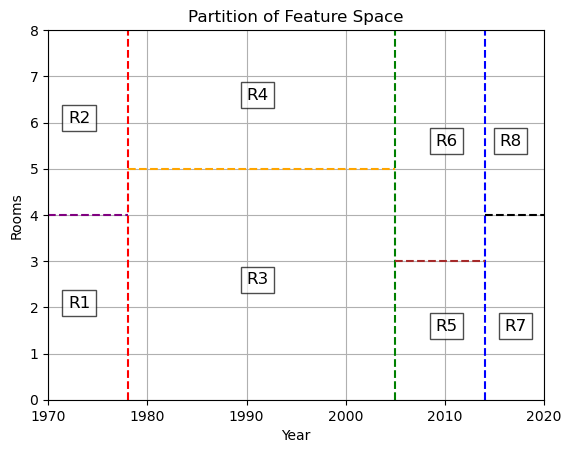

In [417]:
# Define the partition cutpoints
def plot_partition():
    # Create a grid
    x = np.linspace(1970, 2020, 100)
    y = np.linspace(1, 7, 100)
    X, Y = np.meshgrid(x, y)

    # Plot vertical cuts (Year)
    plt.axvline(x=1978, color='r', linestyle='--', label='Year = 1978')
    plt.axvline(x=2005, color='g', linestyle='--', label='Year = 2005')
    plt.axvline(x=2014, color='b', linestyle='--', label='Year = 2014')

    # Plot horizontal cuts (Rooms)
    #plt.hlines(3, 1978, 2014, color='purple', linestyle='--', label='Rooms = 3')
    plt.hlines(5, 1978, 2005, color='orange', linestyle='--', label='Rooms = 5')
    plt.hlines(3, 2005, 2014, color='brown', linestyle='--',  label='Rooms = 6')
    plt.hlines(4, 2014, 2020, color='black', linestyle='--',  label='Rooms = 6')
    plt.hlines(4, 1970, 1978, color='purple', linestyle='--',  label='Rooms = 6')

    # Label regions
    plt.text(1972, 2, 'R1', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(1972, 6, 'R2', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(1990, 2.5, 'R3', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(1990, 6.5, 'R4', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(2009, 1.5, 'R5', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(2009, 5.5, 'R6', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(2016, 1.5, 'R7', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(2015.5, 5.5, 'R8', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Partition of Feature Space")
    plt.xlabel("Year")
    plt.ylabel("Rooms")
    plt.ylim(0, 8)
    
    plt.xlim(1970, 2020)
    #plt.legend()
    plt.grid(True)
    plt.show()

plot_partition()

## Conceptual Question 2
This is question 7 from page 364 ISLP chapter 8

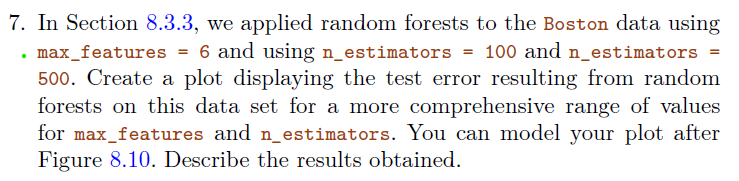

In [420]:
X_train.shape

(404, 12)

In [421]:
Boston = load_data("Boston")
model = ModelSpec(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

X_train,  X_test,  y_train,  y_test = train_test_split(X, Boston['medv'], test_size=0.2, random_state=0)

In [422]:
## function to compute mean squared error.
def compute_mse(y, y_pred):
    # Ensure that both y and y_pred have the same length
    if len(y) != len(y_pred):
        raise ValueError("The length of y and y_pred must be the same.")
    
    # Calculate the MSE
    mse = np.mean((y - y_pred) ** 2)
    return mse

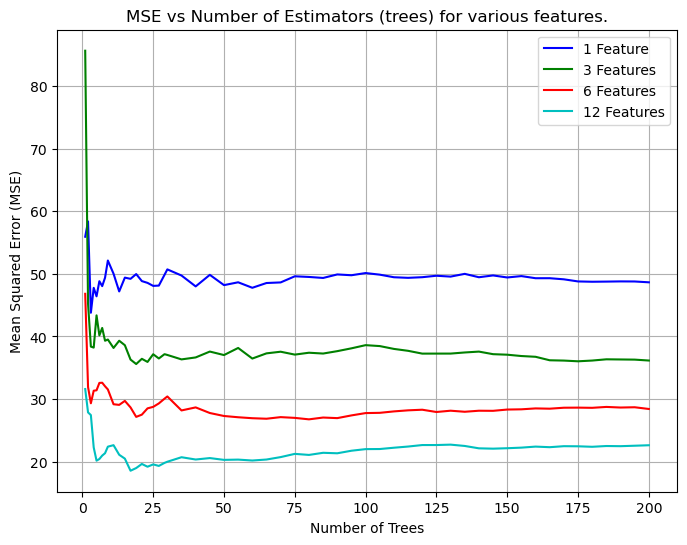

In [434]:
max_number_of_trees = 201
total_features = X_train.shape[1]
mse_by_estimators = []

for n_estimators in range(1, max_number_of_trees+1):
    temp =[n_estimators]
    for max_features in [1, 3, 6, 12]:
        if n_estimators < 10 or (n_estimators < 30 and n_estimators%2 == 1) or (n_estimators >= 30 and n_estimators%5 == 0):
            random_forest_boston = RandomForestRegressor(n_estimators=n_estimators,
                                                           max_depth=3,
                                                           max_features=max_features,
                                                           random_state=11)
            random_forest_boston.fit(X_train, y_train)
            y_pred_test = random_forest_boston.predict(X_test)
            mse = compute_mse(y_test, y_pred_test)
            temp.append(mse)
    if(len(temp)>2):
        mse_by_estimators.append(temp)
results = pd.DataFrame(mse_by_estimators, columns = 'n_estimators mse1Feature mse3Features mse6Features mse12Features'.split())
plt.figure(figsize=(8, 6))
plt.plot(results['n_estimators'], results['mse1Feature'], linestyle='-', color='b', label='1 Feature')
plt.plot(results['n_estimators'], results['mse3Features'], linestyle='-', color='g', label='3 Features')
plt.plot(results['n_estimators'], results['mse6Features'], linestyle='-', color='r', label='6 Features')
plt.plot(results['n_estimators'], results['mse12Features'], linestyle='-', color='c', label='12 Features')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Number of Estimators (trees) for various features.')
plt.legend()
plt.grid(True)
plt.show()